# Illustrating energy dependencies of the model

This notebook demonstrates the contribution of electrons at different energies to the overall Crab Nebula SED using the const. B-field model and its updated 3D representation of Meyer et al. (2010). It also shows how the predicted extension of the nebula can be retrieved as a function of photon energy. 

In [1]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [59]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension, electron_distribution_width
from crabmeyerpy.photonfields import black_body, j_dust_carbon_shell
from crabmeyerpy.data import CrabData
from scipy.integrate import simps, romb
from nonthermal.sync import Esync_peak, gamma_sync_peak
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time
import os

In [3]:
%load_ext autoreload
%autoreload 2

# 3D model

Initialize the 3D model

In [4]:
d = 2.  # distance to Crab in kpc

In [58]:
# config to match 1D case
config_orig = {
    # electron spectrum parameters
    "Nradio": np.exp(-9.5) * 1.3, # these are just some scalings
    "gradio_min": np.exp(3.1),
    "gradio_max": np.exp(12.1),
    "Sradio": -1.60,
    "Nwind": np.exp(-48.) * 2, # these are just some scalings
    "gmin": np.exp(3.1),
    "gmax": np.exp(30.),
    "gwind_min": np.exp(13.1),
    "gwind_max": np.exp(22.6),
    "gwind_b": 1. / np.exp(19.5),
    "Swind": -2.85,
    "Sbreak": -0.6, 
    "sup_wind": 2.8,
    # spatial parameters, this is new
    "gamma_br_const": 34e9 / m_e_eV, # below this gamma value, the nebula has constant size, in Hillas et al: 34. GeV
    "radio_size_cm": np.tan(1.35 * arcmin2rad) * d * kpc2cm,  # constant size of Gaussian below gamma_br_constant in arcmin 
    "index": -0.17,  # power-law index of energy dependency
    "amplitude": np.tan(1.2 * arcmin2rad) * d  * kpc2cm,  # amplitude for PL spatial dependence
    "offset": np.tan(0.15 * arcmin2rad) * d * kpc2cm,  # offset for high energies
    "dust_T": 97.6,
    "dust_norm": 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi,  # for new dust function
    "dust_extension": 1.3,  # extension of nebula in FIR from dust
    "ic_sync": True, 
    "ic_dust": True,
    "ic_cmb": True,
    "B": 124.e-6
}

In [6]:
# read in parameters from Tim
in_dir = "/Users/manuelmeyer/Dropbox/Projects/Crab/data4Manuel/"

#config = np.load(os.path.join(in_dir, "04_all_gaussradio_newdust.npy"), allow_pickle=True).flat[0]  #KC model
config = np.load(os.path.join(in_dir, "v18_hess1+2+mono_newdust_08.npy"), allow_pickle=True).flat[0]  # const B model

# Dieter's crab points
ext_horns=np.loadtxt(os.path.join(in_dir, 'Crab_ext_Horns_erratum.txt'), delimiter=';')

x_horns=(ext_horns[:,0]*u.GeV).to_value("TeV")

fac=np.sqrt(x_horns[1:] / x_horns[:-1])
facs=np.array([1.40251572, 1.40251572, 1.41, 1.415, 1.4, 1.39 , 3, 4])

x_err_horns_p=(facs-1)*x_horns
x_err_horns_n=x_horns*(1-1/facs)

sig_horns=(ext_horns[:,1]*u.deg)#.to_value("arcmin")
err_p_horns=(ext_horns[:,2]*u.deg-sig_horns).to_value("arcmin")
err_n_horns=(sig_horns-ext_horns[:,3]*u.deg).to_value("arcmin")

radio_extensions=np.loadtxt(os.path.join(in_dir,"radio_extensions.txt"), usecols=[0,1,2]) # freq, r68, err r68
radio_extensions[:,0] *= (c.h*u.Hz).to_value('TeV') # convert freq to TeV

In [7]:
config

{'Nradio': 3.0062481900932256e-05,
 'gradio_min': 22.197951281441636,
 'gradio_max': 666938.8574958541,
 'Sradio': -1.5843897407258407,
 'Nwind': 1.4491523256959471e-22,
 'gmin': 22.197951281441636,
 'gmax': 10686474581524.463,
 'gwind_min': 887117.6749845278,
 'gwind_max': 6621461542.315336,
 'gwind_b': 3.2368768455163266e-09,
 'Swind': -3.220971121217105,
 'Sbreak': -0.4408007128989592,
 'sup_wind': 2.8,
 'gamma_br_const': 23384.463537888416,
 'radio_size_cm': 3.232354755272443e+18,
 'index': -0.49999999797684724,
 'amplitude': 1.0278229613135999e+18,
 'dust_T': 151.0,
 'dust_norm': 3e+32,
 'dust_extension': 2.0626478149532494,
 'min_dust_extension': 1.7188732421530424,
 'ic_sync': 1.0,
 'ic_dust': 1.0,
 'ic_cmb': 1.0,
 'B': 0.00011995497330382417,
 'dust_l_min': 0.001,
 'dust_l_max': 0.1,
 'dust_T1': 151.0,
 'dust_T2': 37.0,
 'log10_M1': -4.37,
 'log10_M2': -1.1,
 'abs_norm': 21500.0,
 'abs_index': 1.3,
 'r_min': 1.6971226698202522e+18,
 'r_max': 4.628516372237051e+18,
 'e_scale': 1

In [50]:
config['gamma_br_const'] * (c.m_e * c.c**2.).to("GeV")

<Quantity 11.94943631 GeV>

In [57]:
np.arctan(config['radio_size_cm'] / (d * kpc2cm)) / arcmin2rad

1.8005795829890736

In [79]:
def distr_width_new(gamma, B, **params):
    rho = np.zeros(gamma.shape)
    # nebula size constant in energy for electron energies below 34 GeV
    m = gamma < params['gamma_br_const']
    rho[m] = params['radio_size_cm']
    rho[~m] = params['radio_size_cm'] * (
              np.power(gamma[~m] / params['gamma_br_const'], params['index']))
    return rho

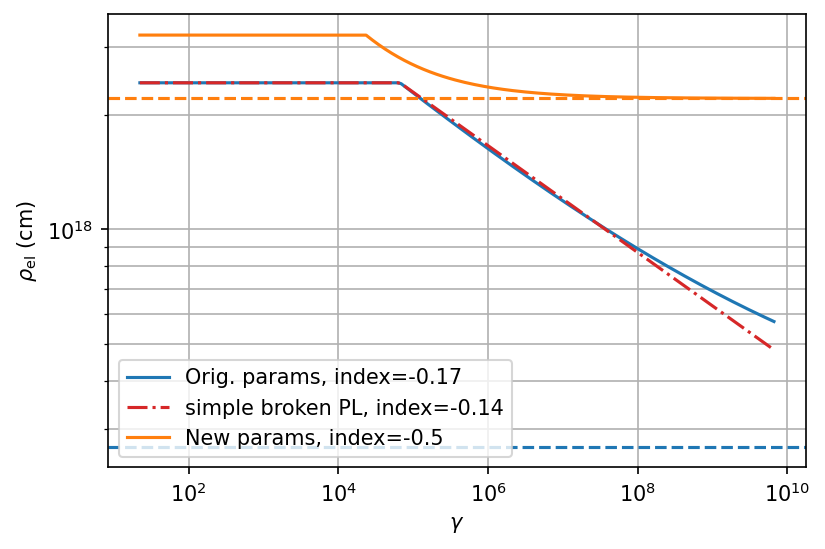

In [87]:
plt.figure(dpi=150)
gamma = np.logspace(np.log10(config['gradio_min']), np.log10(config['gwind_max']), 200)

plt.loglog(gamma, electron_distribution_width(gamma, **config_orig), label="Orig. params, index=-0.17")

config_new_mod = copy.deepcopy(config_orig)
config_new_mod['index'] = -0.14
plt.loglog(gamma, distr_width_new(gamma, **config_new_mod), label="simple broken PL, index=-0.14", ls='-.', color="C3")

plt.loglog(gamma, electron_distribution_width(gamma, **config), label="New params, index=-0.5")

plt.axhline(config['radio_size_cm'] - config['amplitude'], ls='--', color="C1")
plt.axhline(config_orig['radio_size_cm'] - config_orig['amplitude'], ls='--', color="C0")

plt.ylabel(r"$\rho_\mathrm{el}$ (cm)")
plt.xlabel("$\gamma$")
plt.grid(which="both")
plt.legend(loc=3)

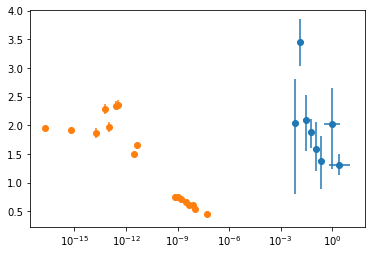

In [8]:
def plot_data(ax=None, y_unit="arcmin", x_unit="TeV"):
    if ax is None:
        ax = plt.gca()
    ax.errorbar(x_horns * u.TeV.to(x_unit),
                sig_horns.to_value(y_unit),
                xerr=[x_err_horns_n * u.TeV.to(x_unit), x_err_horns_p * u.TeV.to(x_unit)],
                yerr=[err_n_horns * u.arcmin.to(y_unit), err_p_horns * u.arcmin.to(y_unit)],
                ls="none", marker="o")
    ax.set_xscale("log")

    ax.errorbar(radio_extensions[:,0] * u.TeV.to(x_unit),
                radio_extensions[:,1] * u.arcsec.to(y_unit),
                yerr=radio_extensions[:,2] * u.arcsec.to(y_unit),
                ls="none", marker="o")
    
plot_data()

In [9]:
print("Break energy of wind spectrum {0:e}eV".format(1. / config['gwind_b'] * m_e_eV))

Break energy of wind spectrum 1.578679e+14eV


In [10]:
# maximum radius of nebula
# This number should probably be updated to newer values
# it comes from Atoyan & Aharonian 1996
r0_pc = 1.8

In [11]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab(gamma, **params) * nel_crab_extension(r, gamma, **params)

# the assumed radial dependence of the magnetic field
def const_B(r, **params):
    result = np.full(r.shape, params['B'])
    return result

Initialize the model

In [12]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, const_B, j_dust_carbon_shell, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG", 
                ic_sync=True, ic_cmb=True, ic_dust=True)

Set the dust parameters

In [13]:
#ssc.parameters['dust_extension'] = 1.3
#ssc.dust_radial_dependence = 'gauss'
#ssc.parameters['dust_norm'] = 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi

#print("Dust extension: {0:.2f} arcmin".format(ssc.parameters['dust_extension']))

## Calculate the full SED

Do one pass of the full SED calculation.

In [14]:
t0 = time.time()
# define r and nu arrays
r = np.linspace(0., ssc.r0, 10)
nu_all = np.logspace(7., 31., 300)

nu_sync = nu_all[nu_all <=1e25]
nu_ic = nu_all[nu_all >= 1e20]

# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

# Calculate the intensities along the line of sight
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu_sync, theta=20)
I_nu_dust, _, _ = ssc.intensity2(nu_sync, theta=20, which='dust')
# Calculate the fluxes
f_nu_sync = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='sync',
                     integration_mode='romb',
                     theta_steps=33)

f_nu_dust = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='dust',
                     integration_mode='romb',
                     theta_steps=33)

# Calculate the IC emissivity
r_ic_egdes = np.linspace(0., ssc.r0, 33)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 129  # steps for integration over gamma
e_steps = 129  # steps for integration over energy of seed photon field
r1_steps = 65   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

# calculate the intensity along the line of sight
I_nu_ic, theta_arcmin_ic, _ = ssc.intensity2(nu_ic, theta=20, which='ic')

# calculate the IC flux
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)
t1 = time.time()
logging.info(f"It took {t1-t0:.2f}s")

/Users/manuelmeyer/Python/miniforge3/envs/basic/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../fast_interp/fast_interp/fast_interp.py", line 329:
@numba.njit(parallel=True)
def _interp2d_k1(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/manuelmeyer/Python/miniforge3/envs/basic/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/depr

In [15]:
nn, rr = np.meshgrid(nu_sync, r, indexing='ij')
ssc.j_dust_nebula(nn, rr).sum()

 ssc_3d.py: 536 --- DEBUG: Dust calculation in j_dust_nebula function took 0.001s


2.9242403558410012e-39

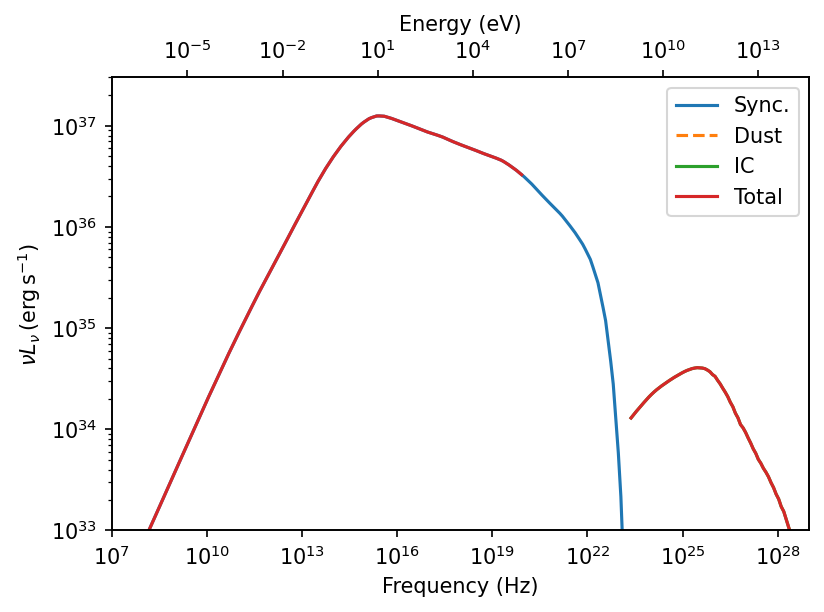

In [17]:
# plotting function to show full sed
def plot_full_sed(luminosity=True, ic=True, sync=True, dust=True, total=True, dpi=150, fig=None, ax=None):
    if fig is None:
        fig = plt.figure(dpi=dpi)

    if ax is None:
        ax = fig.add_subplot(111)
        
    if luminosity:
        const = 4. * np.pi * (d * kpc2cm)**2
    else:
        const = 1.

    if sync:
        ax.loglog(nu_sync, f_nu_sync * nu_sync * const, ls='-', label="Sync.")
    if dust:
        ax.loglog(nu_sync, f_nu_dust * nu_sync * const, ls='--', label="Dust")
    if ic:
        ax.loglog(nu_ic, f_nu_ic * nu_ic * const, ls='-', label="IC")
    if total:
        f_all = np.zeros_like(nu_all)
        m_sync = nu_all <= nu_sync[-1]
        m_ic = nu_all >= nu_ic[0]
        
        f_all[m_sync] += f_nu_sync
        f_all[m_sync] += f_nu_dust
        f_all[m_ic] += f_nu_ic
        
        ax.loglog(nu_all, f_all * nu_all * const, ls='-', label="Total")
    
    if luminosity:
        ax.set_ylim(1e33,3e37)
        ax.set_ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")    

    else:
        ax.set_ylim(1e-13, 1e-7)
        ax.set_ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}$)")    
        
    ax.set_xlim(1e7,1e29)
    ax2 = ax.twiny()
    ax2.set_xlim(1e7 * c.h.to("eV s").value, 1e29 * c.h.to("eV s").value)
    ax2.set_xscale("log")
    ax.set_xlabel("Frequency (Hz)")
    ax2.set_xlabel("Energy (eV)")
    return fig, ax

fig, ax = plot_full_sed()
ax.legend()


### Plot the predicted extension as function of energy 

In order to this, we have to first make sure what we want to plot. The extension comes from the assumed extension for the electron density. In the const. B-field model, the extension of the electron density is modeled with a Gaussian, $n_e(r, \gamma) \propto \exp(-r^2 / (2\sigma(\gamma))$, where the extension $\sigma$ depends on the electron energy $\gamma$. However, what we observe is the extension in photon energies. 

What we have readily available from the code is the intensity as a function of angular separation and photon energy:

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

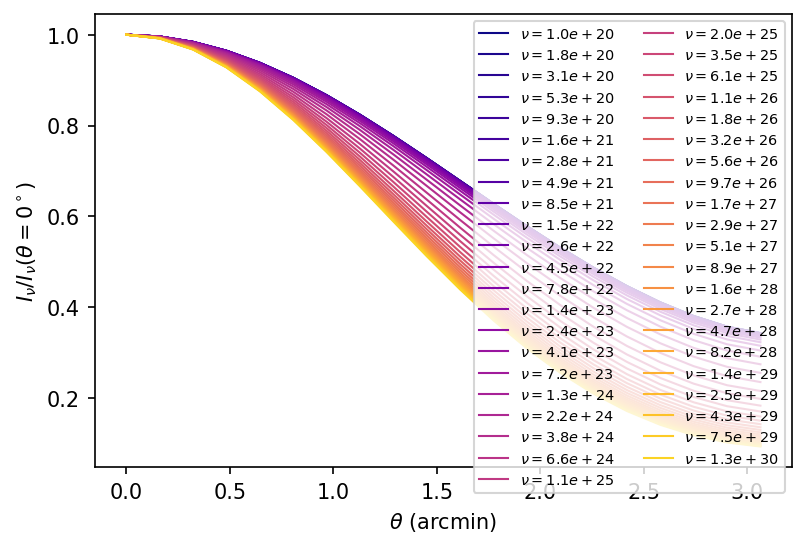

In [49]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_ic[:-10]):
    if i % 3:
        continue
        
    plt.plot(theta_arcmin_ic, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$\nu={0:.1e}$".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

In [22]:
for i, t in enumerate(theta_arcmin[1:]):
    #print (f_nu_ic_theta.shape, i)
    cdf_sync[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], t],
                           which='sync',
                           integration_mode='romb',
                           theta_steps=33)

(225,)

In [43]:
# flux form factor for different frequencies
f_nu_sync_theta = np.zeros((theta_arcmin.size - 1, nu_sync.size))

for i, t in enumerate(theta_arcmin_ic[1:]):
    f_nu_sync_theta[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], t],
    #f_nu_sync_theta[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[i-1], t],
                                 which='sync',
                                 integration_mode='romb',
                                 r_steps=65,
                                 theta_steps=65)

In [44]:
f_nu_sync_theta.shape

(19, 225)

Text(0, 0.5, '$F_\\nu / F_\\nu(\\theta = 0^\\circ)$')

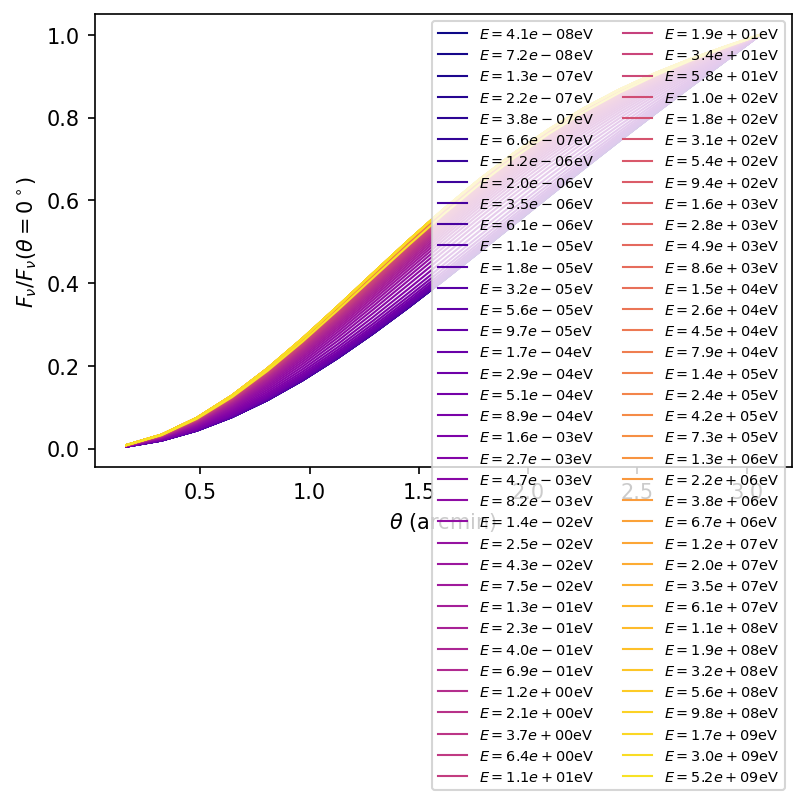

In [48]:
plt.figure(dpi=150)
for i, n in enumerate(nu_sync[:-10]):
    if i % 3:
        continue
        
    plt.plot(theta_arcmin[1:], f_nu_sync_theta[:, i] / f_nu_sync_theta[-1, i],
               color=plt.cm.plasma(i / float(nu_sync.size)),
               label=r"$E={0:.1e}$eV".format(n * c.h.value * u.J.to("eV")),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F_\nu / F_\nu(\theta = 0^\circ)$")

From this, we can derive the flux as an integral over $\theta$ subtained over some interval $\Delta\theta$. This we can use to find the value of $\theta$ where $q = 68\%$ of the emissino is contained. We call this the model extension. 

In [22]:
# first we calculate the flux over an ever larger range of theta
# in order to get the CDF

cdf_ic = np.zeros((theta_arcmin_ic.size - 1, nu_ic.size))
for i, t in enumerate(theta_arcmin_ic[1:]):
    #print (f_nu_ic_theta.shape, i)
    cdf_ic[i] = ssc.flux(nu_ic, theta_edges=[theta_arcmin_ic[0], t],
                         which='ic',
                         integration_mode='romb',
                         r_steps=65,
                         theta_steps=65)
    
cdf_sync = np.zeros((theta_arcmin.size - 1, nu_sync.size))
for i, t in enumerate(theta_arcmin[1:]):
    #print (f_nu_ic_theta.shape, i)
    cdf_sync[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], t],
                           which='sync',
                           integration_mode='romb',
                           theta_steps=33)
    
cdf_sync = cdf_sync.T
cdf_ic = cdf_ic.T

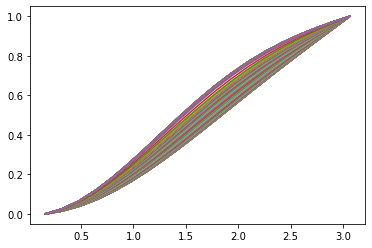

In [23]:
# now we loop through the frequencies and for each frequency 
# determine the radius where 68% of the emission is contained
from scipy.interpolate import UnivariateSpline as USpline

q = 0.68

# loop through frequencies
roots_ic = np.zeros(cdf_ic.shape[0])
for i, _ in enumerate(cdf_ic):
    # normalize CDF and subtract q
    cdf_q = (cdf_ic[i] - cdf_ic[i,0]) / (cdf_ic[i,-1] - cdf_ic[i,0]) - q
    # interpolate
    intp_inv = USpline(theta_arcmin_ic[1:], cdf_q, k=3, s=0)
    #plt.plot(theta_arcmin_ic[1:], cdf_q + q)
    # find the root, i.e. size that corresponds to 0.68 quantile
    roots_ic[i] = intp_inv.roots()[0]
    
roots_sync = np.zeros(cdf_sync.shape[0])
for i, _ in enumerate(cdf_sync):
    # normalize CDF and subtract q
    cdf_q = (cdf_sync[i] - cdf_sync[i,0]) / (cdf_sync[i,-1] - cdf_sync[i,0]) - q
    # interpolate
    intp_inv = USpline(theta_arcmin[1:], cdf_q, k=3, s=0)
    plt.plot(theta_arcmin[1:], cdf_q + q)
    # find the root, i.e. size that corresponds to 0.68 quantile
    roots_sync[i] = intp_inv.roots()[0]

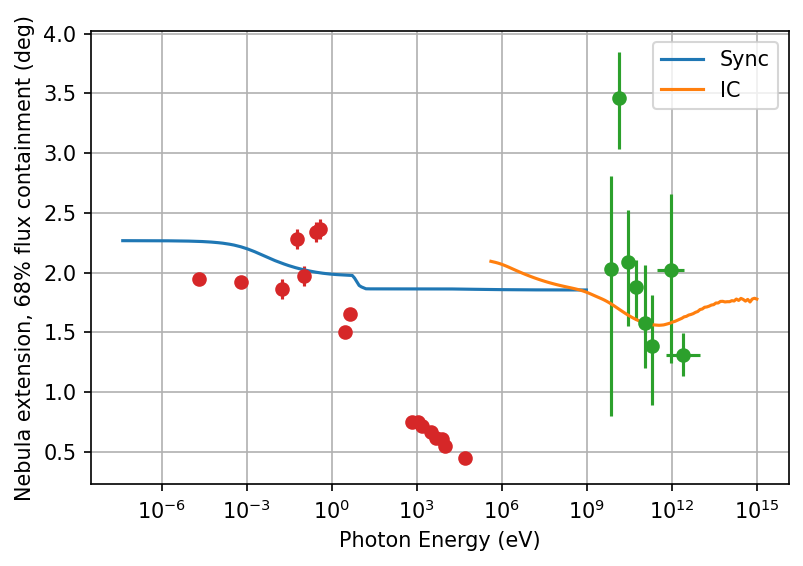

In [27]:
plt.figure(dpi=150)
sl = slice(None, -20, None)
plt.semilogx(nu_sync[sl] * c.h.to("eV s"), np.rad2deg(roots_sync[sl] * arcmin2rad) * u.deg.to("arcmin"), label="Sync")
plt.semilogx(nu_ic[sl] * c.h.to("eV s"), np.rad2deg(roots_ic[sl] * arcmin2rad) * u.deg.to("arcmin"), label="IC")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Nebula extension, 68% flux containment (deg)")
plt.grid()
plt.legend()

plot_data(x_unit="eV")